In [ ]:
from IPython.display import Image
import __main__
import numpy as np
import cv2
from mvextractor.videocap import VideoCap
from sklearn.neighbors import NearestNeighbors
import ipywidgets as widgets
import cv2
import matplotlib.pyplot as plt
import pandas as pd




# Détection des météores en utilisant mv-extractor

Ce notebook à pour but de montrer l'utilisation de mv-extractor (https://github.com/LukasBommes/mv-extractor.git) pour au final detecter des météores sur une vidéo

## 1 - Ouverture de la vidéo

In [9]:
cap = VideoCap()
video_url = "../vid_mpeg4_part2.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

## 1 - Extraction et Affichage des vecteurs vitesses

### 1.1 - Extraction des vecteurs vitesses

Avec la commande ~$ extract_mvs vid_h264.mp4 --dump, cela lance l'extraction par défaut, nous pouvons afficher les vecteurs vitesses de chaque frame de la vidéo. De plus pour chaque image, il y a un fichier .npy associé avec la description des vecteurs.

-- dump permet de stocker les images avec les vecteurs vitesses.

### 1.2 - Affichage des vecteurs vitesses

-- preview permet d'afficher la vidéo

Sinon, en se placant dans le dossier mv-extractor, on peut lancer la commande : ~$ python3 src/mvextractor/__main__.py vid_h264.mp4 --dump --preview, qui lance notre propre fichier avec nos modifications. Par exemple, une image de Big Buck Bunny au format H264 :

In [10]:
cap = VideoCap()
video_url = "../vid_mpeg4_part2.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

def draw_motion_vectors(frame, motion_vectors):

    if len(motion_vectors) > 0:
        num_mvs = np.shape(motion_vectors)[0]
        for mv in np.split(motion_vectors, num_mvs):
            start_pt = (mv[0, 3], mv[0, 4])
            end_pt = (mv[0, 5], mv[0, 6])
            #if (np.sqrt(np.abs((end_pt[0]-start_pt[0])^2+(end_pt[1]-start_pt[1])^2))>5):
            cv2.arrowedLine(frame, start_pt, end_pt, (70, 255, 255), 1, cv2.LINE_AA, 0, 0.1)
    return frame

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    frame = draw_motion_vectors(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

Nous pouvons voir les vecteurs sur le lapin qui doit être en train de sortir de son terrier.

Aussi, de nombreux points de couleurs sont sur l'image, ce sont aussi des vecteurs vitesses mais avec une norme faible. Nous pourrons par la suite trouver une solution pour les supprimer et ainsi conserver uniquement les vecteurs "intéressant".

### 1.3 - Extraction des données sous forme de tableau

En plus de cette image, nous avons un fichier numpy associé. Pour l'extraire et le manipuler nous utilisons la bibliothèque pandas.

In [ ]:
# Charger un fichier .npy
data = np.load('../outputs_frames/BBB MPEG4/motion_vectors/mvs-33.npy')
pd.set_option('display.max_rows', None)
df = pd.DataFrame(data)

# Afficher le DataFrame
print(data)
print(data.dtype)

[[-1 16 16 ... -3 -3  2]
 [-1 16 16 ... -2 -2  2]
 [-1 16 16 ... -2 -2  2]
 ...
 [-1 16 16 ... -2 -2  2]
 [-1 16 16 ... -2 -2  2]
 [-1 16 16 ... -2 -2  2]]
int32


Le tableau possède donc 10 colonnes et plus de 3000 lignes (le nombre de vecteurs vitesses).


#### Description des colonnes :
1. Colonne 0 : Désigne la frame de référence pour la frame actuelle, si <0 alors c'est une frame passé, si >0 alors frame future. Pour le moment on utilise uniquement les frames passés.
2. Colonne 3 : src_x : Coordonnées de x (en pixels) dans la frame de référence
3. Colonne 4 : src_y : Coordonnées de y (en pixels) dans la frame de référence
4. Colonne 5 : dst_x : Coordonnées de x (en pixels) dans la frame actuelle
5. Colonne 6 : dst_y : Coordonnées de y (en pixels) dans la frame actuelle
6. Colonne 7 : motion_x = motion_scale * (src_x - dst_x), longueur du vecteur en x
7. Colonne 8 : motion_y = motion_scale * (src_y - dst_y), longueur du vecteur en y
8. Colonne 9 : motion_scale : Utiliser pour transformer motion_x et motion_y en integer. Par exemple si motion_scale=4, les composantes motions peuvent être un int mais encode un float avec 1/4 pixel precision.

### 1.4 - Affichage des vecteurs sous fond noir

Sur la vidéo suivante on peut voir les déplacements du lapin sur fond noir.

In [12]:
cap = VideoCap()
video_url = "../vid_mpeg4_part2.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

def draw_motion_vectors_black(frame, motion_vectors):
    black_frame = np.zeros_like(frame)
    if len(motion_vectors) > 0:
        num_mvs = np.shape(motion_vectors)[0]
        for mv in np.split(motion_vectors, num_mvs):
            start_pt = (mv[0, 3], mv[0, 4])
            end_pt = (mv[0, 5], mv[0, 6])
            #if (np.sqrt(np.abs((end_pt[0]-start_pt[0])^2+(end_pt[1]-start_pt[1])^2))>5):
            cv2.arrowedLine(black_frame, start_pt, end_pt, (70, 255, 255), 1, cv2.LINE_AA, 0, 0.1)
    return black_frame

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    frame = draw_motion_vectors_black(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

## 2 - Filtre sur les vecteurs
### 2.1 - Filtre sur la norme

La première idée serait de conserver les vecteurs avec une norme suffisament importante, vous pouvez jouer sur la norme avec le curseur ci dessous 

In [13]:
### Ne marche pas pour le moment

# Créez un slider pour ajuster la norme de sélection des vecteurs
norm_slider = widgets.FloatSlider(value=10, min=0, max=100, step=1, description="Norme:")

# Affichez le slider
display(norm_slider)

value = norm_slider.value

FloatSlider(value=10.0, description='Norme:', step=1.0)

In [14]:
cap = VideoCap()
video_url = "../vid_mpeg4_part2.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

def select_vectors_norm(motion_vectors, value):
    start_pt = motion_vectors[:, [3, 4]]
    end_pt = motion_vectors[:, [5, 6]]
    norm = np.linalg.norm(end_pt - start_pt, axis=1)
    return motion_vectors[norm>value]

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    motion_vectors=select_vectors_norm(motion_vectors, 10)
    frame = draw_motion_vectors(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

Nous pouvons donc remarquer que tous les vecteurs qui ressemblaient plus à des "points" ont disparus. Choisir une norme supérieur à 10 pour cette frame est surement pas la meilleure solution, il serait plus intéressant de prendre une norme légérement inférieur pour essayer d'avoir le dessin du lapin en vecteur.

Une autre idée serait d'isoler des zones ou il y a de nombreux vecteurs vitesses pour détecter les météores ou autres objets en mouvements. Combiné au masque de la norme, nous pourrions obtenir des résultats intéressants.

Par la suite, un algorithme de type knapstack pourra être implementé. L'idée serait de maximiser une zone en faisant la somme des normes des vecteurs vitesses tout en minimisant le nombre de vecteurs utilisé. De plus, dans le cas des météores, nous pourrions ajouter une condition sur le sens et la direction des vecteurs. En effet, les météores ont un mouvement rectiligne, tous les vecteurs devront avoir le même sens et une direction assez similaire. 

### 2.2 Filtre sur la zone

Une autre idée serait de conserver uniquement les vecteurs qui possède des voisins assez proches et en nombre suffisants. Pour cela on peut utiliser le module,NearestNeighbors de python qui permet de trouver les voisins les plus proches. Ainsi,nous pouvons appliquer un filtre en conservant uniquement les vecteurs ayant un nombre minimum de voisins proches.
Tout d'abord on peut regarder une frame avec une météorite sans filtre :

In [15]:
cap = VideoCap()
video_url = "../vid_mpeg4_part2.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

def select_vectors_zone(motion_vectors):
    if motion_vectors.shape[0] == 0:
        return motion_vectors
    
    start_pt = motion_vectors[:, [3, 4]]
    end_pt = motion_vectors[:, [5, 6]]

    min_neighbors = 2
    distance_threshold = 16

    #Utiliser NearestNeighbors pour trouver les voisins proches des points finaux
    nbrs = NearestNeighbors(radius=distance_threshold).fit(end_pt)
    distances, indices = nbrs.radius_neighbors(end_pt)

    # Filtrer les vecteurs qui ont au moins `min_neighbors` voisins proches pour leurs points finaux
    mask = [len(neighbors) > min_neighbors for neighbors in indices]

    return motion_vectors[mask]

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    motion_vectors=select_vectors_zone(motion_vectors)
    frame = draw_motion_vectors(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

Les résultats en filtrant uniquement sur la zone ne sont pas bons, on peut alors combiner le filtre sur la norme et la zone.

### 2.3 Filtre Norme et Zone

In [16]:
cap = VideoCap()
video_url = "../vid_mpeg4_part2.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

def select_vectors_zone(motion_vectors):
    if motion_vectors.shape[0] == 0:
        return motion_vectors
    
    start_pt = motion_vectors[:, [3, 4]]
    end_pt = motion_vectors[:, [5, 6]]

    min_neighbors = 2
    distance_threshold = 16

    #Utiliser NearestNeighbors pour trouver les voisins proches des points finaux
    nbrs = NearestNeighbors(radius=distance_threshold).fit(end_pt)
    distances, indices = nbrs.radius_neighbors(end_pt)

    # Filtrer les vecteurs qui ont au moins `min_neighbors` voisins proches pour leurs points finaux
    mask = [len(neighbors) > min_neighbors for neighbors in indices]

    return motion_vectors[mask]

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    motion_vectors=select_vectors_norm(motion_vectors, 10)
    motion_vectors=select_vectors_zone(motion_vectors)
    frame = draw_motion_vectors(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

Nous obtenons un bon suivi du lapin, on pourrait l'améliorer en modifiant les paramètres de la zone et de la norme

### 2.4 Avec une vidéo de météore

In [17]:
cap = VideoCap()
video_url = "../v03.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    frame = draw_motion_vectors(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

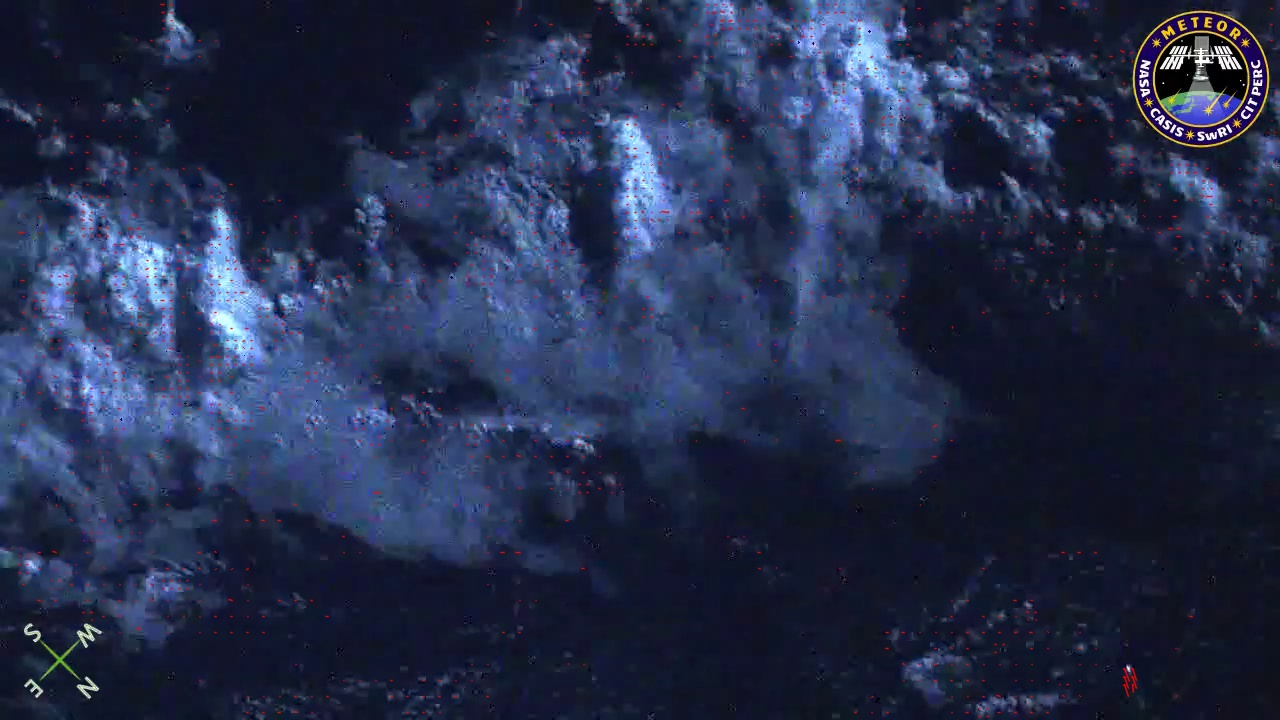

In [23]:
Image("../outputs_frames/mission Chiba sans filtre/frames/frame-102.jpg")

Nous pouvons donc remarquer de nombreux vecteurs "inutiles".
Maintenant en appliquant un filtre sur la norme et la zone en fixant une distance maximum de 16 et au minumum 3 voisins proches par exemple, nous obtenons :

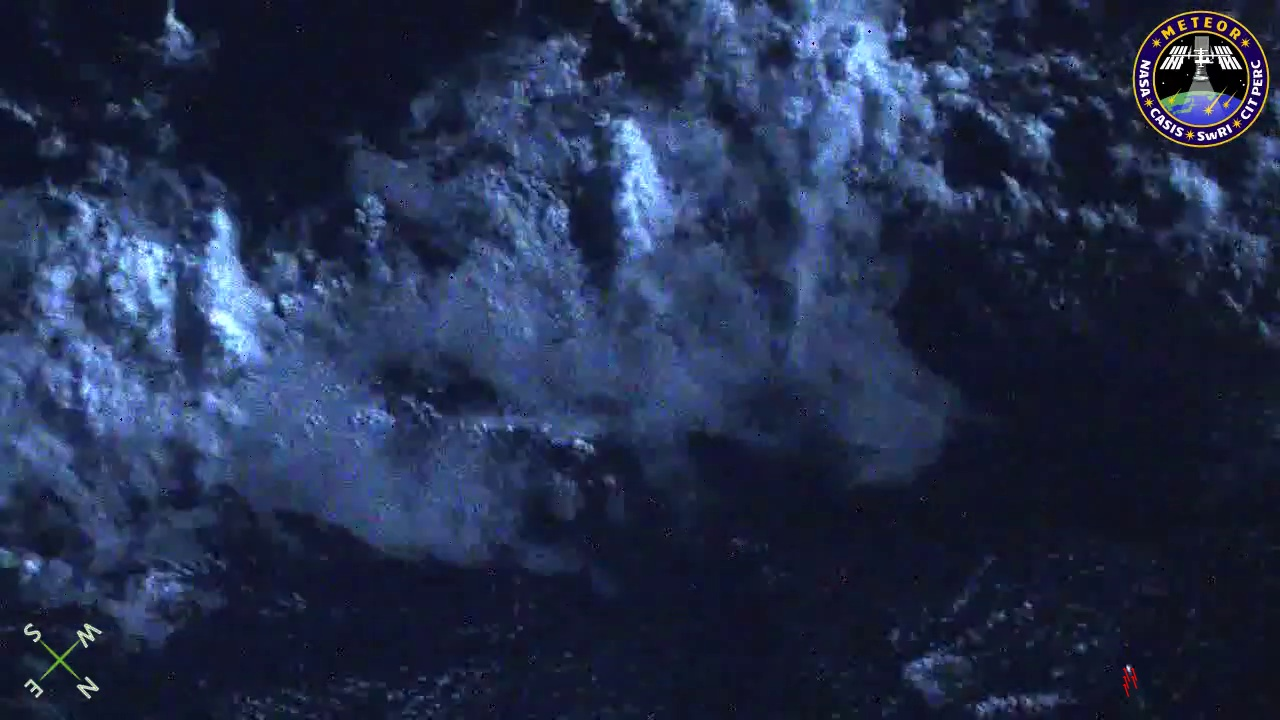

In [19]:
Image("../outputs_frames/Mission Chiba norme+zone/frames/frame-102.jpg")

Avec cette méthode nous arrivons à isoler le météore. 

Bien que nous ayons réussi à détecter le météore, cette méthode reste toujours imprécise car nous fixons les paramètres manuellement et n'est donc pas reproductibles.

## 3 - Rogner la zone d'intérêt

Nous pouvons aussi couper l'image pour garder uniquement la zone ou est situé la météorite, par exemple avec l'image précédente.

In [20]:
#Crop to zoom on vector zone
def crop_frame(frame,motion_vectors):
    if motion_vectors.shape[0] == 0 :
        return frame
    start_x = motion_vectors[:, 3]
    start_y = motion_vectors[:, 4]
    end_x = motion_vectors[:, 5]
    end_y = motion_vectors[:, 6]
    
    # Trouver les coordonnées minimales et maximales
    min_x = int(min(np.min(start_x), np.min(end_x)))
    max_x = int(max(np.max(start_x), np.max(end_x)))
    min_y = int(min(np.min(start_y), np.min(end_y)))
    max_y = int(max(np.max(start_y), np.max(end_y)))
    
    
    # Rogner la frame selon ces limites
    cropped_frame = frame[(min_y):(max_y), (min_x):(max_x)]
    
    return cropped_frame

cap = VideoCap()
video_url = "../v03.mp4"  # Modifier avec l'URL de votre vidéo
ret = cap.open(video_url)

if not ret:
    raise RuntimeError(f"Could not open {video_url}")

step=0
while True:
    ret, frame, motion_vectors, frame_type, timestamp = cap.read()
    motion_vectors=select_vectors_norm(motion_vectors, 10)
    motion_vectors=select_vectors_zone(motion_vectors)
    frame = draw_motion_vectors(frame, motion_vectors)
    frame=crop_frame(frame, motion_vectors)
    cv2.imshow("Frame", frame)
    # if user presses "q" key stop program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    step+=1
cap.release()

# close the GUI window
cv2.destroyAllWindows()

In [21]:
Image("../outputs_frames/Mission Chiba crop/frames/frame-102.jpg")

On a bien zoomer sur la vidéo, nous pourrions augmenté la taille de la coupe pour mieux récupérer la zone d'intérêt.